In [2]:
from PIL import Image
import torch
import clip   # pip install openai-clip
import struct
import os
import matplotlib.pyplot as plt
import gzip
import numpy as np

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 下载模型
# https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
# 下载数据
# http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
# http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

In [4]:
# 加载模型
def load_model(model_path, text_label):
    model, process = clip.load(model_path, device=device)
    text = clip.tokenize(text_label).to(device)
    return model, process, text


# 预测
def predict(model, process, image, text):
    with torch.no_grad():
        image = process(image).unsqueeze(0).to(device)
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=1).cpu().numpy()
    label = ""
    prob = 0.0
    for i in range(len(text_label)):
        # print(f"Label='{text_label[i]}', prob={probs[0][i]}")
        if probs[0][i] > prob:
            prob = probs[0][i]
            label = text_label[i]
    return label

def un_gz(file_name):
    """ungz zip file"""
    f_name = file_name.replace(".gz", "")
    #获取文件的名称，去掉
    g_file = gzip.GzipFile(file_name)
    #创建gzip对象
    open(f_name, "wb+").write(g_file.read())
    #gzip对象用read()打开后，写入open()建立的文件里。
    g_file.close() #关闭gzip对象
    

def load_data(data_path):
    """
    http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
    http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
    :param data_path:
    :return:
    """
    un_gz(data_path)
    data_path = data_path.replace(".gz", "")
    # 读取二进制数据
    bin_data = open(data_path, 'rb').read()

    # 解析文件头信息，依次为魔数、图片数量、每张图片高、每张图片宽
    offset = 0
    fmt_header = '>iiii'  # 因为数据结构中前4行的数据类型都是32位整型，所以采用i格式，但我们需要读取前4行数据，所以需要4个i。我们后面会看到标签集中，只使用2个ii。
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)

    # 解析数据集
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)  # 获得数据在缓存中的指针位置，从前面介绍的数据结构可以看出，读取了前4行之后，指针位置（即偏移位置offset）指向0016。
    fmt_image = '>' + str(
        image_size) + 'B'  # 图像数据像素值的类型为unsigned char型，对应的format格式为B。这里还有加上图像大小784，是为了读取784个B格式数据，如果没有则只会读取一个值（即一副图像中的一个像素值）
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images


def load_label(data_path):
    un_gz(data_path)
    data_path = data_path.replace(".gz", "")
    with open(data_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    return labels


def score(y, pre):
    # 计算整体准确率
    n = len(y)
    if n == 0:
        return 0
    cnt = 0
    for i in range(n):
        if y[i] == pre[i]:
            cnt += 1
        else:
            pass
    return cnt/n


def score_by_cls(y, pre):
    # 分别计算每个类别的准确率
    dic = dict()
    n = len(y)
    if n == 0:
        return None

    for i in range(n):
        label = y[i]
        pre_label = pre[i]
        if label not in dic:
            dic[label] = (0, 0)
        if label == pre_label:
            dic[label] = (dic[label][0] + 1, dic[label][1] + 1)
        else:
            dic[label] = (dic[label][0] + 1, dic[label][1])

    for key in dic:
        dic[key] = dic[key][1]/dic[key][0]

    return dic

accuracy: 0.6459
accuracy by classes: {'an image of a ankle boot': 0.719, 'an image of a pullover': 0.912, 'an image of a trouser': 0.893, 'an image of a shirt': 0.04, 'an image of a coat': 0.193, 'an image of a sandal': 0.444, 'an image of a sneaker': 0.962, 'an image of a dress': 0.736, 'an image of a bag': 0.92, 'an image of a t-shirt': 0.64}


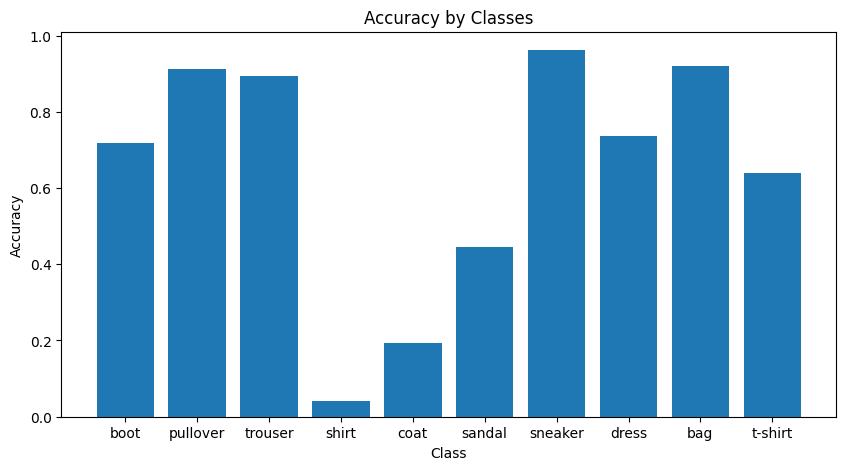

In [8]:
if __name__ == '__main__':
   
    # https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
    model_path = "/data/lab/ass2/ViT-B-32.pt"
    data_path = "/data/lab/ass2/cifar-10-python.tar.gz"
    MAX_IMAGES = 10000 # 调整该参数可设定要测试多少张图片
    mnist_classes = ["t-shirt", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    # text_label = ["a image of the handwritten digit: '%s'"%item for item in mnist_classes]
    text_label = ["an image of a %s" % item for item in mnist_classes]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, process, text = load_model(model_path, text_label)
    imgs = load_data("/data/lab/ass2/t10k-images-idx3-ubyte.gz")
    labels = load_label("/data/lab/ass2/t10k-labels-idx1-ubyte.gz")
    imgs = imgs.reshape(len(imgs), 28, 28)
    imgs = np.array(imgs, dtype=np.uint8)
    true_label_lst = []
    predict_label_lst = []
    
    for i in range(len(imgs)):
        img = imgs[i]
        img = Image.fromarray(img)
        label = text_label[labels[i]]
        pre_label = predict(model, process, img, text)
        true_label_lst.append(label)
        predict_label_lst.append(pre_label)
        #print(f"{label}, {pre_label}")
        if i > 10000:
            break
    s = score(true_label_lst, predict_label_lst)
    s_cls = score_by_cls(true_label_lst, predict_label_lst)
    print(f"accuracy: {s}")
    print(f"accuracy by classes: {s_cls}")
    plt.figure(figsize=(10, 5))
    plt.bar([item.split(" ")[-1] for item in s_cls.keys()], s_cls.values())
    plt.title("Accuracy by Classes")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.show()